In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Data Preparation

## U.S. Census Data

In [2]:
def census_import(census_file_p1, census_file_p2, census_year, row_limit=None): # import scorecard files
    """Import census file for relevant data"""
    
    census_cols = ['AGEP', 'SCHL', 'FOD1P', 'FOD2P', 'ADJINC', 'WAGP', 'SEMP', 'ESR']
    census_dtypes = {'FOD1P': str, 'ADJINC': float, 'WAGP': float, 'SEMP': float}
    df = pd.read_csv(census_file_p1, usecols=census_cols, dtype=census_dtypes, 
                     na_values={'bbbbbb', ' '}, nrows=row_limit) #bbbbbb refers to N/A
    df = pd.concat([df, pd.read_csv(census_file_p2, usecols=census_cols, dtype=census_dtypes, 
                   na_values={'bbbbbb', ' '}, nrows=row_limit)]) 
        
    # since the scorecards only track up to 10 years for a cohort, we are only concerned with ages between 22 and 29
    df = df[(df['AGEP'] < 29) & (df['AGEP'] > 21)]    
    # we are only concerned with people who have an educational attainment of Bachelor's (value = 21)
    df = df[df['SCHL'] == 21]
    # we are only concerned with those with a single degree
    df = df[df['FOD2P'].isnull()]
    
    df['Census Year'] = census_year
    # specify a cohort year for each age based on the assumption of entering the college force at 18
    df['Cohort Year'] = census_year - (df['AGEP'] - 18)
    df['Years Post-Entry'] = census_year - df['Cohort Year']
    df['ADJINC'] = df['ADJINC'] / 1000000 # income adjustment for inflation factor implies six decimal places
    df['Employed'] = df['ESR'].isin([1,2,4,5]) 
    df['Working'] = df['ESR'].isin([1,4]) # ESR includes cases of employed but not working
    df['Earnings'] = (df['WAGP'].astype(float) + df['SEMP'].astype(float)) * df['ADJINC']
        # The combination of wage and self-employed income - cast as float due to convention change from 2014 file
        # adjusted for inflation

    df.rename(columns = {'FOD1P':'Major', 'AGEP':'Age', 'ADJINC':'Income Adj. Factor', 'WAGP': 'Wage Income',
                        'SEMP': 'Self-Employed Income'}, inplace=True)
    
    df.set_index(pd.Index(df['Census Year']), drop=True, append=True, inplace=True)
    
    return df[['Age', 'Years Post-Entry', 'Cohort Year', 'Major', 'Income Adj. Factor', 'Wage Income', 
               'Self-Employed Income', 'Earnings', 'Employed', 'Working']]

In [7]:
# list of all census files to import
census_filelist = [
                    ["ss09pusa.csv", "ss09pusb.csv", 2009],                 
                    ["ss10pusa.csv", "ss10pusb.csv", 2010], 
                    ["ss11pusa.csv", "ss11pusb.csv", 2011], 
                    ["ss12pusa.csv", "ss12pusb.csv", 2012], 
                    ["ss13pusa.csv", "ss13pusb.csv", 2013], 
                    ["ss14pusa.csv", "ss14pusb.csv", 2014], 
                    ["ss15pusa.csv", "ss15pusb.csv", 2015], 
                    ["ss16pusa.csv", "ss16pusb.csv", 2016]
                    ]

# import all years of census data
for i in range(len(census_filelist)):
    if i == 0:
        census_data = census_import(census_filelist[i][0],census_filelist[i][1], census_filelist[i][2])
    else:        
        census_data = pd.concat([census_data, 
                                 census_import(
                                     census_filelist[i][0],census_filelist[i][1], census_filelist[i][2])])
        
census_data.head()

,,Age,Years Post-Entry,Cohort Year,Major,Income Adj. Factor,Wage Income,Self-Employed Income,Earnings,Employed,Working
,Census Year,,,,,,,,,,
332,2009,28,10,1999,2407,0.99948,37500.0,0.0,37480.5000,True,False
350,2009,24,6,2003,6106,0.99948,900.0,0.0,899.5320,False,False
351,2009,24,6,2003,3600,0.99948,2500.0,0.0,2498.7000,False,False
360,2009,25,7,2002,5503,0.99948,38500.0,0.0,38479.9800,True,True
471,2009,23,5,2004,5200,0.99948,960.0,0.0,959.5008,False,False


In [10]:
# import major to degree type mapping file
maj_to_degtype_df = pd.read_csv('Majors to Degree Type Mapping.csv', dtype={'Major':str})

# join census data to mapping to add degree type
census_with_deg_df = pd.merge(census_data, maj_to_degtype_df, how ='left', left_on='Major', right_on='Major', 
                             left_index=True).set_index(census_data.index)

# export data to a single save file to avoid having to reimport data sets each run
census_with_deg_df.to_csv('Relevant Census Data.csv')

census_with_deg_df.head()

,,Age,Years Post-Entry,Cohort Year,Major,Income Adj. Factor,Wage Income,Self-Employed Income,Earnings,Employed,Working,Major Name,Degree Type
,Census Year,,,,,,,,,,,,
332,2009,28,10,1999,2407,0.99948,37500.0,0.0,37480.5000,True,False,COMPUTER ENGINEERING,PCIP14
350,2009,24,6,2003,6106,0.99948,900.0,0.0,899.5320,False,False,HEALTH AND MEDICAL PREPARATORY PROGRAMS,PCIP51
351,2009,24,6,2003,3600,0.99948,2500.0,0.0,2498.7000,False,False,BIOLOGY,PCIP26
360,2009,25,7,2002,5503,0.99948,38500.0,0.0,38479.9800,True,True,CRIMINOLOGY,PCIP45
471,2009,23,5,2004,5200,0.99948,960.0,0.0,959.5008,False,False,PSYCHOLOGY,PCIP42


In [2]:
# import the pre-generated relevant census data
relevant_census_df = pd.read_csv('Relevant Census Data.csv', index_col=[0, 'Census Year'], 
                                 dtype={'Earnings':float})

In [3]:
def census_aggregation(relevant_census_df): # aggregates census data to the cohort year, major level
    """Aggregates census data to find average income and working rate by degree type"""
    
    df = relevant_census_df
    group_cols = ['Cohort Year', 'Years Post-Entry', 'Degree Type']
    
    # average income
    relevant_incomes = df[df['Working'] == True]
    df_avg_inc = relevant_incomes.groupby(group_cols).agg({'Earnings': 'mean', 'Working': 'count'})
    df_avg_inc.rename(columns = {'Working': 'n-Income'}, inplace = True)
    
    # working status count and rate
    df_working = pd.pivot_table(df[group_cols + ['Working']], index = group_cols, 
                                 columns = 'Working', aggfunc = len)
    df_working.rename(columns = {False: 'Not Working', True: 'Working'}, inplace = True)
    df_working.fillna(0, inplace = True)
    df_working['n-Working Status'] = df_working['Working'] + df_working['Not Working']
    df_working['Working Rate'] = df_working['Working'] / df_working['n-Working Status']
    
    # combine the average income and employment summaries
    df_agg = pd.concat([df_avg_inc, df_working], axis =  1)
    df_agg.fillna(0, inplace = True)
    
    return df_agg


In [4]:
# aggregate the census data
census_agg = census_aggregation(relevant_census_df)
#census_agg.to_csv('census_agg.csv')
census_agg.head()

Earnings  n-Income  Not Working  \
Cohort Year Years Post-Entry Degree Type                                        
1999        10               PCIP01       38320.467030      99.0         12.0   
                             PCIP03       41540.887500      16.0          2.0   
                             PCIP04       45772.614429      56.0         11.0   
                             PCIP05       35928.675789      19.0          4.0   
                             PCIP09       40556.364507     426.0         70.0   

                                          Working  n-Working Status  \
Cohort Year Years Post-Entry Degree Type                              
1999        10               PCIP01          99.0             111.0   
                             PCIP03          16.0              18.0   
                             PCIP04          56.0              67.0   
                             PCIP05          19.0              23.0   
                             PCIP09         426.0             496.0   

                                          Working Rate  
Cohort Year Years Post-Entry Degree Type                
1999        10               PCIP01           0.891892  
                             PCIP03           0.888889  
                             PCIP04           0.835821  
                             PCIP05           0.826087  
                             PCIP09           0.858871

## College Scorecards

In [333]:
def scorecard_import(scorecard_filename, scorecard_year): # import scorecard files
    """Import scorecard file for relevant data"""

    df_header = pd.read_csv(scorecard_filename, nrows = 0)    
    # create a list of the degree awarded percentage columns (begins with PCIP)
    deg_awarded_cols = [col for col in df_header if col.startswith('PCIP')]
    # create a list of mean earnings columns
    mean_earnings_cols = [col for col in df_header if col.startswith('MN_EARN_WNE_P')]
    # create a list of n-working
    count_working_cols = [col for col in df_header if col.startswith('COUNT_WNE_P')]
    # create a list of n-notworking
    count_notworking_cols = [col for col in df_header if col.startswith('COUNT_NWNE_P')]
    # create a list of quartile columns (begins with pct25_earn, md_earn, or pct75_earn)
    q1_cols = [col for col in df_header if col.startswith('PCT25_EARN')]
    q2_cols = [col for col in df_header if col.startswith('MD_EARN')] 
    q3_cols = [col for col in df_header if col.startswith('PCT75_EARN')]
    
    # define specific columns to import
    scorecard_cols = ['UNITID','INSTNM', 'INSTURL', 'SCH_DEG']
    scorecard_cols.extend(deg_awarded_cols + mean_earnings_cols + count_working_cols + count_notworking_cols + 
                 q1_cols + q2_cols + q3_cols)
    
    df = pd.read_csv(scorecard_filename, index_col = 'UNITID', usecols = scorecard_cols, 
                     na_values={'PrivacySuppressed'})    
    df.index.names = ['Institution ID']
    df.rename(columns={'INSTNM': 'Institution Name', 'INSTURL': 'Institution URL'},
              inplace=True)
    
    # filter out data
    df = df[df['SCH_DEG'] == 3] # only store data on schools that offer bachelor's degrees
    # remove schools with more than 5% degrees in PCIP47 due to no majors mapping to it
    df = df[df['PCIP47'] < 0.05]
    # remove specialized schools
    df = df[df[deg_awarded_cols].apply(lambda x: (x < 0.5).all(), axis = 1)]
    
    # add extra fields
    df['Scorecard Year'] = scorecard_year
    # degree for a scorecard year is at the graduation of the cohort which entered 4 years prior (assumed for a 4 year program)
    df['Degree Cohort Year'] = scorecard_year - 4
    df.set_index(['Scorecard Year', 'Degree Cohort Year'], append = True, inplace = True)

    return df # should the degree value file contain all years or are they separate files?

In [334]:
# list of all scorecard files to import
scorecard_filelist = [
                    ['MERGED2004_05_PP.csv', 2004], 
                    ['MERGED2005_06_PP.csv', 2005],                 
                    ['MERGED2006_07_PP.csv', 2006], 
                    ['MERGED2007_08_PP.csv', 2007], 
                    ['MERGED2008_09_PP.csv', 2008], 
                    ['MERGED2009_10_PP.csv', 2009], 
                    ['MERGED2010_11_PP.csv', 2010], 
                    ['MERGED2011_12_PP.csv', 2011], 
                    ['MERGED2012_13_PP.csv', 2012], 
                    ['MERGED2013_14_PP.csv', 2013], 
                    ['MERGED2014_15_PP.csv', 2014], 
                    ['MERGED2015_16_PP.csv', 2015], 
                    ]

# import all years of census data
for i in range(len(scorecard_filelist)):
    if i == 0:
        scorecard_data = scorecard_import(scorecard_filelist[i][0], scorecard_filelist[i][1])
    else:        
        scorecard_data = pd.concat([scorecard_data, 
                                 scorecard_import(
                                     scorecard_filelist[i][0], scorecard_filelist[i][1])])

# export data to a single save file to avoid having to reimport data sets each run
scorecard_data.to_csv('Relevant Scorecard Data.csv')

scorecard_data.head()

,,,Institution Name,Institution URL,SCH_DEG,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,...,MN_EARN_WNE_P7,COUNT_NWNE_P8,COUNT_WNE_P8,MN_EARN_WNE_P8,MD_EARN_WNE_P8,PCT25_EARN_WNE_P8,PCT75_EARN_WNE_P8,COUNT_NWNE_P9,COUNT_WNE_P9,MN_EARN_WNE_P9
Institution ID,Scorecard Year,Degree Cohort Year,,,,,,,,,,,,,,,,,,,,,
100654,2004,2000,Alabama A & M University,NaN,3.0,0.0458,0.0068,0.0119,0.0000,0.0000,0.0492,0.0747,...,32500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100663,2004,2000,University of Alabama at Birmingham,NaN,3.0,0.0000,0.0000,0.0000,0.0019,0.0583,0.0000,0.0338,...,40400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100706,2004,2000,University of Alabama in Huntsville,NaN,3.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0568,...,44400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100724,2004,2000,Alabama State University,NaN,3.0,0.0000,0.0000,0.0000,0.0000,0.0610,0.0000,0.1441,...,27800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100751,2004,2000,The University of Alabama,NaN,3.0,0.0000,0.0000,0.0000,0.0040,0.1319,0.0000,0.0089,...,42700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# import the pre-generated relevant scorecard data
scorecard_data = pd.read_csv('Relevant Scorecard Data.csv', index_col=[0,1,2], 
                             dtype={'Institution ID':str, 'Institution URL': str})

scorecard_data.head()

,,,Institution Name,Institution URL,SCH_DEG,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,...,MN_EARN_WNE_P7,COUNT_NWNE_P8,COUNT_WNE_P8,MN_EARN_WNE_P8,MD_EARN_WNE_P8,PCT25_EARN_WNE_P8,PCT75_EARN_WNE_P8,COUNT_NWNE_P9,COUNT_WNE_P9,MN_EARN_WNE_P9
Institution ID,Scorecard Year,Degree Cohort Year,,,,,,,,,,,,,,,,,,,,,
100654,2004,2000,Alabama A & M University,NaN,3.0,0.0458,0.0068,0.0119,0.0000,0.0000,0.0492,0.0747,...,32500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100663,2004,2000,University of Alabama at Birmingham,NaN,3.0,0.0000,0.0000,0.0000,0.0019,0.0583,0.0000,0.0338,...,40400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100706,2004,2000,University of Alabama in Huntsville,NaN,3.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0568,...,44400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100724,2004,2000,Alabama State University,NaN,3.0,0.0000,0.0000,0.0000,0.0000,0.0610,0.0000,0.1441,...,27800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100751,2004,2000,The University of Alabama,NaN,3.0,0.0000,0.0000,0.0000,0.0040,0.1319,0.0000,0.0089,...,42700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def yearly_degrees(relevant_scorecards_df): # takes the degree data and associates it with a cohort
    """Separates the degree data from the post-grad data and associates it with the correct cohort"""
    
    df = relevant_scorecards_df.copy() # make a copy due to renaming index
    # since this data set is only about degrees, rename 'Degree Cohort Year' for clarity
    df.index.names = ['Institution ID', 'Scorecard Year', 'Cohort Year']
    
    # create a list of the degree awarded percentage columns (begins with PCIP)
    deg_awarded_cols = [col for col in df if col.startswith('PCIP')]
    
    df = pd.DataFrame(df[deg_awarded_cols].stack())
    df.rename(columns={0:'Pct of Degrees Awarded'}, inplace=True)
    df.index.names = ['Institution ID', 'Scorecard Year', 'Cohort Year', 'Degree Type']
    
    return df

In [7]:
# create a separate copy of just the degrees issued data
degree_breakdown = yearly_degrees(scorecard_data)
#degree_breakdown.to_csv('degree breakdown.csv')
degree_breakdown.head()

Pct of Degrees Awarded
Institution ID Scorecard Year Cohort Year Degree Type                        
100654         2004           2000        PCIP01                       0.0458
                                          PCIP03                       0.0068
                                          PCIP04                       0.0119
                                          PCIP05                       0.0000
                                          PCIP09                       0.0000

In [404]:
def scorecard_pe_data(relevant_scorecards_df): # takes the post-grad follow-up data for evaluation
    """Converts the columns that indicate earnings and employment data at x years post-entry cohort
    into metric categories indexed by the post-entry year"""
    
    df = relevant_scorecards_df.copy() # make a copy specifically for the post-grad data
    
    # create a list of mean earnings columns
    mean_earnings_cols = [col for col in df if col.startswith('MN_EARN_WNE_P')]
    # create a list of n-working
    count_working_cols = [col for col in df if col.startswith('COUNT_WNE_P')]
    # create a list of n-notworking
    count_notworking_cols = [col for col in df if col.startswith('COUNT_NWNE_P')]
    # create a list of quartile columns (begins with pct25_earn, md_earn, or pct75_earn)
    q1_cols = [col for col in df if col.startswith('PCT25_EARN')]
    q2_cols = [col for col in df if col.startswith('MD_EARN')] 
    q3_cols = [col for col in df if col.startswith('PCT75_EARN')]
    
    # create a list of the columns specifically associated with a post-entry year
    time_cols = []
    time_cols.extend(mean_earnings_cols + count_working_cols + count_notworking_cols + 
                 q1_cols + q2_cols + q3_cols)
    
    df = pd.DataFrame(df[time_cols].stack())
    df.reset_index(level=[1,3], inplace=True)
    df.sort_index(inplace=True)
    
    df['Years Post-Entry'] = np.where(df['level_3'].str[-2:] == '10', 10, df['level_3'].str[-1:]).astype(int)
    df['Cohort Year'] = df['Scorecard Year'] - df['Years Post-Entry']
    
    df.loc[df['level_3'].isin(mean_earnings_cols), 'Data Type'] = 'Avg Earnings'
    df.loc[df['level_3'].isin(count_working_cols), 'Data Type'] = 'Working Count'
    df.loc[df['level_3'].isin(count_notworking_cols), 'Data Type'] = 'Not Working Count'
    df.loc[df['level_3'].isin(q1_cols), 'Data Type'] = 'Earnings Q1'
    df.loc[df['level_3'].isin(q2_cols), 'Data Type'] = 'Earnings Q2'
    df.loc[df['level_3'].isin(q3_cols), 'Data Type'] = 'Earnings Q3'
    
    df.drop('level_3',axis = 1, inplace = True)
    df = df.pivot_table(index=['Institution ID','Cohort Year', 'Years Post-Entry','Scorecard Year'], 
                        columns='Data Type',values=0)
    
    df['Working Rate'] = np.where((df['Working Count'].notnull()) & (df['Not Working Count'].notnull()),
        df['Working Count'] / (df['Working Count'] + df['Not Working Count']), np.NaN)
    
    # add the institution name
    df = pd.merge(df.reset_index(), relevant_scorecards_df['Institution Name'].reset_index(), 
                  on=['Institution ID', 'Scorecard Year'])
    df.set_index(['Institution ID','Cohort Year', 'Years Post-Entry','Scorecard Year'], inplace=True)
    return df

In [405]:
# generate the post-entry breakdown using the loaded data relevant scorecard data
pe_breakdown = scorecard_pe_data(scorecard_data)
#pe_breakdown.to_csv('pe_breakdown.csv')
pe_breakdown.head()

Avg Earnings  \
Institution ID Cohort Year Years Post-Entry Scorecard Year                 
100654         1997        7                2004                 32500.0   
                           8                2005                 34500.0   
               1999        6                2005                 29400.0   
               1997        9                2006                 36500.0   
               1999        7                2006                 31700.0   

                                                            Earnings Q1  \
Institution ID Cohort Year Years Post-Entry Scorecard Year                
100654         1997        7                2004                    NaN   
                           8                2005                19400.0   
               1999        6                2005                14600.0   
               1997        9                2006                    NaN   
               1999        7                2006                    NaN   

                                                            Earnings Q2  \
Institution ID Cohort Year Years Post-Entry Scorecard Year                
100654         1997        7                2004                    NaN   
                           8                2005                32200.0   
               1999        6                2005                25700.0   
               1997        9                2006                    NaN   
               1999        7                2006                    NaN   

                                                            Earnings Q3  \
Institution ID Cohort Year Years Post-Entry Scorecard Year                
100654         1997        7                2004                    NaN   
                           8                2005                45800.0   
               1999        6                2005                38900.0   
               1997        9                2006                    NaN   
               1999        7                2006                    NaN   

                                                            Not Working Count  \
Institution ID Cohort Year Years Post-Entry Scorecard Year                      
100654         1997        7                2004                         83.0   
                           8                2005                         87.0   
               1999        6                2005                        115.0   
               1997        9                2006                        102.0   
               1999        7                2006                        125.0   

                                                            Working Count  \
Institution ID Cohort Year Years Post-Entry Scorecard Year                  
100654         1997        7                2004                    969.0   
                           8                2005                   1036.0   
               1999        6                2005                   1134.0   
               1997        9                2006                   1085.0   
               1999        7                2006                   1296.0   

                                                            Working Rate  \
Institution ID Cohort Year Years Post-Entry Scorecard Year                 
100654         1997        7                2004                0.921103   
                           8                2005                0.922529   
               1999        6                2005                0.907926   
               1997        9                2006                0.914069   
               1999        7                2006                0.912034   

                                                            Degree Cohort Year  \
Institution ID Cohort Year Years Post-Entry Scorecard Year                       
100654         1997        7                2004                          2000   
                           8                2005              

In [332]:
def census_pcip_sampling(samp_size): # creates samples from the census data to estimate quartile values
    """In order to discount the effects of degree on each school's quartile earnings data,
    the best that can be done is to recreate a random sample of the population with in the
    proportions of the cohort's degree type data. NOTE: very long run time!"""
    
    # initialize df
    df = pd.DataFrame(columns=['Institution ID','Cohort Year','Years Post-Entry','Degree Type','Earnings'])
    
    deg_rates = pd.merge(degree_breakdown.reset_index(), pe_breakdown.reset_index(), 
                         on=['Institution ID','Cohort Year'])
    
    # create a list of institutions that require samples
    instit_list = [x for x in deg_rates['Institution ID'].unique().tolist()]
    
    deg_rates.set_index(['Institution ID','Cohort Year','Years Post-Entry','Degree Type'], inplace=True)
    deg_rates = deg_rates.loc[:,['Pct of Degrees Awarded']]
    deg_rates = deg_rates[deg_rates['Pct of Degrees Awarded'] > 0].sort_index()
    
    data = relevant_census_df.reset_index()[['Cohort Year','Years Post-Entry','Degree Type','Earnings']]

    for instit in instit_list:
        #print(instit) # uncomment to monitor progress
        instit_rates = deg_rates.loc[instit]
        
        # get relevant census data based on the cohorts and pe years
        rel_data = pd.merge(instit_rates.reset_index(), data.reset_index(), 
                            on=['Cohort Year','Years Post-Entry','Degree Type'])
        rel_data.set_index(['Cohort Year','Years Post-Entry','Degree Type'],inplace=True)
        rel_data = pd.DataFrame(rel_data['Earnings'])
        
        if rel_data.empty: # skip to next if no data available
            continue 
        
        # pull n samples amongst the degrees based on the weightings of the degree breakdown
        samples = rel_data.groupby(['Cohort Year', 'Years Post-Entry']).apply(
            pd.DataFrame.sample,n=samp_size, weights=instit_rates['Pct of Degrees Awarded'], replace=True
            ).reset_index(level=[0,1],drop=True)
        
        samples['Institution ID'] = instit
        
        # append to collected list of samples
        df = df.append(samples.reset_index())
        
    
    return df


In [424]:
# run sampling and save
q_samples = census_pcip_sampling(300)
q_samples.to_csv('Quartile Sampling Data.csv')

### Determining College Estimated Degree Value

** Average **

In [406]:
def find_exp_earn_wr(census_agg_df, degree_breakdown_df): # find expected earnings and working rate
    """Using the average earnings for individuals with the same field of study,
    created a weighted average based on each institution's graduates to determine expected earnings.
    This should represent the value of the fields of study independent of the value added by the university."""
    
    df = pd.merge(census_agg_df.reset_index(), degree_breakdown_df.reset_index(), on=['Cohort Year', 'Degree Type'],
            how='inner').set_index(['Institution ID', 'Cohort Year', 'Years Post-Entry', 'Degree Type'])

    df['Exp Earnings'] = round(df['Earnings'] * df['Pct of Degrees Awarded'],2)
    df['Exp Working Rate'] = df['Working Rate'] * df['Pct of Degrees Awarded']
    df = df.groupby(['Institution ID', 'Cohort Year', 'Years Post-Entry',]).sum()
    
    # ignore cases where earnings or working rate is 0 as errors
    df = df[(df['Exp Earnings'] > 0) & df['Exp Working Rate'] > 0]
    
    return df[['Exp Earnings', 'Exp Working Rate']]

exp_earn_wr = find_exp_earn_wr(census_agg, degree_breakdown)
#exp_earn_wr.to_csv('exp_earn_wr.csv')
exp_earn_wr.head()

Exp Earnings  Exp Working Rate
Institution ID Cohort Year Years Post-Entry                                
100654         2000        9                     42979.82          0.840069
                           10                    43484.65          0.838581
               2001        8                     39548.53          0.837367
                           9                     42242.76          0.839890
                           10                    43932.06          0.824263

** Quartiles **

In [342]:
# read saved quartile sampling data
q_samples = pd.read_csv('Quartile Sampling Data.csv', index_col=0)
q_samples.head()

C:\Users\kevin\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [407]:
# estimate quartiles using sampled data
est_quartiles = q_samples.groupby(['Institution ID', 'Cohort Year', 'Years Post-Entry']
                                 ).quantile([0.25,0.5,0.75]).unstack().reset_index(col_level=1)
est_quartiles.columns = est_quartiles.columns.droplevel()
est_quartiles.rename(columns={
    0.25:'Est Q1 Earnings', 0.5:'Est Q2 Earnings', 0.75:'Est Q3 Earnings'},inplace=True)
est_quartiles.head()

,Institution ID,Cohort Year,Years Post-Entry,Est Q1 Earnings,Est Q2 Earnings,Est Q3 Earnings
0,100654,2001,8,19989.6000,35981.2800,46975.5600
1,100654,2001,9,21840.2502,35065.3152,50381.2000
2,100654,2001,10,19346.5030,36147.4135,54984.7980
3,100654,2002,10,19193.9330,38387.8660,54046.0745
4,100654,2003,6,11519.0070,25786.5840,37005.7470


### Determining College Premium

In [409]:
# take the difference between the average of the scorecard and the estimated college's degree value
# generates a premium to earnings and working rate
def find_avg_col_premium(pe_breakdown_df, exp_earn_wr_df):
    """Using census data on post-earnings data and deducting the expected earnings should leave us with 
    the value added by the specific college."""

    df = pd.merge(pe_breakdown_df.reset_index(), exp_earn_wr_df.reset_index(), 
              on=['Institution ID', 'Cohort Year', 'Years Post-Entry'],
            how='inner')
    df = df.merge(est_quartiles.reset_index(), on=['Institution ID', 'Cohort Year', 'Years Post-Entry']
                 ).set_index(['Institution ID', 'Cohort Year', 'Years Post-Entry'])
    df['Avg Earnings Premium'] = df['Avg Earnings'] - df['Exp Earnings']
    df['Working Rate Premium'] = df['Working Rate'] - df['Exp Working Rate']
    df['Premium Q1'] = df['Earnings Q1'] - df['Est Q1 Earnings']
    df['Premium Q2'] = df['Earnings Q2'] - df['Est Q1 Earnings']
    df['Premium Q3'] = df['Earnings Q3'] - df['Est Q1 Earnings']
    
    return df[['Institution Name', 'Avg Earnings', 'Avg Earnings Premium', 
               'Earnings Q1', 'Earnings Q2', 'Earnings Q3', 'Premium Q1', 'Premium Q2', 'Premium Q3', 
               'Working Rate', 'Working Rate Premium']]

avg_col_premium = find_avg_col_premium(pe_breakdown, exp_earn_wr)
#avg_col_premium.to_csv('avg_col_premium.csv')
avg_col_premium#.head()

Institution Name  \
Institution ID Cohort Year Years Post-Entry                                                      
100654         2001        8                                          Alabama A & M University   
               2003        6                                          Alabama A & M University   
               2001        9                                          Alabama A & M University   
               2003        7                                          Alabama A & M University   
               2001        10                                         Alabama A & M University   
               2003        8                                          Alabama A & M University   
               2005        6                                          Alabama A & M University   
               2002        10                                         Alabama A & M University   
               2004        8                                          Alabama A & M University   
               2006        6                                          Alabama A & M University   
               2003        10                                         Alabama A & M University   
               2005        8                                          Alabama A & M University   
               2007        6                                          Alabama A & M University   
100663         2001        8                               University of Alabama at Birmingham   
               2003        6                               University of Alabama at Birmingham   
               2001        9                               University of Alabama at Birmingham   
               2003        7                               University of Alabama at Birmingham   
               2001        10                              University of Alabama at Birmingham   
               2003        8                               University of Alabama at Birmingham   
               2005        6                               University of Alabama at Birmingham   
               2002        10                              University of Alabama at Birmingham   
               2004        8                               University of Alabama at Birmingham   
               2006        6                               University of Alabama at Birmingham   
               2003        10                              University of Alabama at Birmingham   
               2005        8                               University of Alabama at Birmingham   
               2007        6                               University of Alabama at Birmingham   
100706         2001        8                               University of Alabama in Huntsville   
               2003        6                               University of Alabama in Huntsville   
               2001        9                               University of Alabama in Huntsville   
               2003        7                               University of Alabama in Huntsville   
...                                                                                        ...   
447290         2003        6                                        Brown Mackie College-Miami   
                           7                                        Brown Mackie College-Miami   
447661         2007        6                      University of Phoenix-Northern Nevada Campus   
448309         2005        6                 Shorter University-College of Adult & Professi...   
               2006        6                 Shorter University-College of Adult & Professi...   
448628         2006        6                                        Westwood College-Annandale   
               2007        6                                        Westwood College-Annandale   
448804         2005        6                                       The Robert B Miller College   
               2006        6                                

## Rankings

### Ranking 1 - U.S. News & World

In [387]:
def import_us_news(): # import the us news rankings
    df = pd.read_csv('Ranking - US News.csv', index_col=['Institution ID', 'Institution Name'])
    
    # flatten years to a single column
    df = pd.DataFrame(df.stack())
    
    df = df.reset_index()
    df.rename(columns={'level_2': 'Cohort Year', 0:'Rank'}, inplace=True)
    df['Cohort Year'] = df['Cohort Year'].astype(int)
    
    # create an inverted ranking so that the top item is scored higher
    df['Inverted Rank'] = df.groupby('Cohort Year')['Rank'].rank(ascending=False)
    
    df.set_index(['Institution ID', 'Cohort Year'], inplace=True)
    
    return df

In [388]:
ranking_1 = import_us_news()
ranking_1.head()

Institution Name  Rank  Inverted Rank
Institution ID Cohort Year                                          
243744         1983         Stanford University   1.0           14.0
               1985         Stanford University   1.0           10.0
               1988         Stanford University   1.0           26.0
               1989         Stanford University   6.0           20.0
               1990         Stanford University   6.0           20.0

### Ranking 2 - Academic Ranking of World Universities (Shanghai Ranking)

In [389]:
def import_ARWU(): # import the ARWU ranking
    df = pd.read_csv('Ranking - ARWU.csv', dtype={'unit no': int})
    
    df.rename(columns={'name': 'Institution Name', 'unit no': 'Institution ID', 
                       'rank':'Rank', 'year': 'Cohort Year'}, inplace=True)
    
    # create an inverted ranking so that the top item is scored higher
    df['Inverted Rank'] = df.groupby('Cohort Year')['Rank'].rank(ascending=False)
    
    df.set_index(['Institution ID', 'Cohort Year'], inplace=True)
    df = df[['Institution Name', 'Rank', 'Inverted Rank']]
    
    return df

In [390]:
ranking_2 = import_ARWU()
ranking_2.head()

,,Institution Name,Rank,Inverted Rank
Institution ID,Cohort Year,,,
166027,2003,Harvard University,1,57.0
243744,2003,Stanford University,2,56.0
110404,2003,California Institute of Technology,3,55.0
110635,2003,University of California Berkeley,4,54.0
166683,2003,Massachusetts Institute of Technology,6,53.0


### Ranking 3 - Times Higher Education / QS

In [391]:
def import_QS(): # import the QS ranking
    df = pd.read_csv('Ranking - QS.csv')
    
    df.rename(columns={'name': 'Institution Name', 'unit id': 'Institution ID',
                       'rank':'Rank', 'year': 'Cohort Year'}, inplace=True)
    
    # create an inverted ranking so that the top item is scored higher
    df['Inverted Rank'] = df.groupby('Cohort Year')['Rank'].rank(ascending=False)
    
    df.set_index(['Institution ID', 'Cohort Year'], inplace=True)
    df = df[['Institution Name', 'Rank', 'Inverted Rank']]
    
    return df

In [392]:
ranking_3 = import_QS()
ranking_3.head()

,,Institution Name,Rank,Inverted Rank
Institution ID,Cohort Year,,,
166027,2004,Harvard University,1,62.0
110635,2004,University of California Berkeley,2,61.0
166683,2004,Massachusetts Institute of Technology MIT,3,60.0
110404,2004,California Institute of Technology Caltech,4,59.0
243744,2004,Stanford University,7,58.0


## Preparing Data Frames for Analysis

In [410]:
# join the predicted rankings to reality data
r1_join = pd.merge(avg_col_premium.reset_index(), ranking_1.reset_index(), how='left', 
                   on=['Institution ID', 'Cohort Year'])
r2_join = pd.merge(avg_col_premium.reset_index(), ranking_2.reset_index(), how='left', 
                   on=['Institution ID', 'Cohort Year'])
r3_join = pd.merge(avg_col_premium.reset_index(), ranking_3.reset_index(), how='left', 
                   on=['Institution ID', 'Cohort Year'])
r3_join.head()

,Institution ID,Cohort Year,Years Post-Entry,Institution Name_x,Avg Earnings,Avg Earnings Premium,Earnings Q1,Earnings Q2,Earnings Q3,Premium Q1,Premium Q2,Premium Q3,Working Rate,Working Rate Premium,Institution Name_y,Rank,Inverted Rank
0,100654,2001,8,Alabama A & M University,32500.0,-7048.53,15300.0,28200.0,43500.0,-4689.600,8210.400,23510.400,0.883109,0.045742,NaN,NaN,NaN
1,100654,2003,6,Alabama A & M University,27800.0,-3019.08,12800.0,25000.0,37700.0,1280.993,13480.993,26180.993,0.876443,0.075365,NaN,NaN,NaN
2,100654,2001,9,Alabama A & M University,33800.0,-8442.76,NaN,NaN,NaN,NaN,NaN,NaN,0.873156,0.033266,NaN,NaN,NaN
3,100654,2003,7,Alabama A & M University,29600.0,-5929.12,NaN,NaN,NaN,NaN,NaN,NaN,0.871483,0.047031,NaN,NaN,NaN
4,100654,2001,10,Alabama A & M University,35300.0,-8632.06,16800.0,31400.0,47000.0,-2546.503,12053.497,27653.497,0.877434,0.053171,NaN,NaN,NaN


In [411]:
# return the joint df of a given ranking vs. reality, aggregated to the post-entry working years
def create_rank_df(joined_ranking, rank_by, only_relevant=False):
    """Takes the joined data and ranks the reality portion based on rank_by to create a data frame.
    If only_relevant is True, then only the predicted_rank colleges are used. 
    If only_relevant is False, then only the top colleges equal to the number of predicted_rank items are selected.
    If a top-n college was not predicted, then its prediction is assigned to the lowest rank."""
    
    group_cols = ['Cohort Year', 'Years Post-Entry']
    
    joined_df = joined_ranking.copy()
    
    # create an inverted ranking for the result data based on rank_by
    joined_df['Inverted Result Rank'] = joined_df.groupby(group_cols)[rank_by].rank()
    
    # keep relevant columns
    keep_cols = ['Cohort Year', 'Years Post-Entry', 'Institution ID', 'Institution Name_x', 
                 'Inverted Rank', 'Inverted Result Rank']
    joined_df = joined_df[keep_cols].sort_values('Inverted Result Rank', ascending=False)

    joined_df.set_index(group_cols, inplace=True)
    
    if only_relevant:
        # filter data to those with a predicted rank
        joined_df = joined_df[joined_df['Inverted Rank'].notnull()]
        
    else:
        # filter data to the top n values from scorecard ranking for each group
        #print(joined_df[joined_df['Inverted Rank'].notnull()]['Institution ID'].groupby(group_cols).count())
        joined_df['top_n'] = joined_df[joined_df['Inverted Rank'].notnull()]['Institution ID'].groupby(
                                                                            group_cols).count()
        joined_df = joined_df.groupby(group_cols).head(joined_df['top_n'])
        # fill in null values
        joined_df['Inverted Rank'].fillna(0, inplace=True)
        joined_df.drop(columns=['top_n'],inplace=True)
    
    # add a new layer of rank after filter?
    
    joined_df.rename(columns={'Institution Name_x': 'Institution Name'},inplace=True)
    joined_df.sort_index(inplace=True)
    
    return joined_df

In [412]:
# systematically create data frames of every ranking compared to every metric and only_relevant combination
ranking_dict = {1: 'US News',
                2: 'ARWU',
                3: 'QS/THE'}
ranking_list = [r1_join, r2_join, r3_join]
metrics = ['Avg Earnings', 'Avg Earnings Premium', 
           'Earnings Q1', 'Earnings Q2', 'Earnings Q3', 'Premium Q1', 'Premium Q2', 'Premium Q3',
           'Working Rate', 'Working Rate Premium']
frames = {}

for i in range(len(ranking_list)):
    for metric in metrics:
        # use i+1 so that the number used to call is the ranking's number
        frames[i+1, metric, False] = create_rank_df(ranking_list[i], metric, False)
        frames[i+1, metric, True] = create_rank_df(ranking_list[i], metric, True)


---

# Data Analysis

In [396]:
%matplotlib inline

In [413]:
# commonly used data frame column lists for convenience
rank_cols = ['Inverted Rank', 'Inverted Result Rank']
group_cols = ['Cohort Year', 'Years Post-Entry']


## Missing Rate of Schools
One way of assessing the rankings is for a given sized n-ranking by each, what percentage of the actual top-n rankings were missed.

In [414]:
def missing_rates(metric): # create data frame of missing schools
    
    df = pd.DataFrame()
    
    # add data for each ranking
    for i in [1,2,3]:
        # we know a ranking is missing if it was given a fillna value of 0
        data = frames[i,metric,False][rank_cols].astype(bool).groupby('Cohort Year').sum(axis=0)
        data['Ranking'] = ranking_dict[i]
        df = df.append(data)
        
    df['Present'] = df['Inverted Rank'] / df['Inverted Result Rank']
    df['Missing'] = 1 - df['Present']
    
    return df[['Ranking','Present','Missing']]

miss_df = missing_rates('Avg Earnings').reset_index()
#miss_df = missing_rates('Earnings Premium').reset_index()
miss_df.head()

,Cohort Year,Ranking,Present,Missing
0,2001,US News,0.619048,0.380952
1,2002,US News,0.640000,0.360000
2,2003,US News,0.637755,0.362245
3,2004,US News,0.648148,0.351852
4,2005,US News,0.611111,0.388889


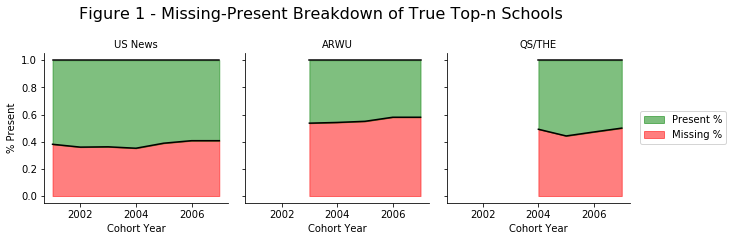

In [415]:
# visualize missing rates
miss_plot = sns.FacetGrid(miss_df, col='Ranking')
miss_plot.map(plt.plot, 'Cohort Year', 'Missing', color='black')

miss_df['All'] = 1
miss_plot.map(plt.plot,'Cohort Year', 'All', color='black')
miss_plot.map(plt.fill_between, 'Cohort Year','Missing', color='red', alpha=0.5)
miss_plot.map(plt.fill_between, 'Cohort Year','Missing', 'All', color='green', alpha=0.5).set_titles('{col_name}')

# format
miss_plot.fig.suptitle('Figure 1 - Missing-Present Breakdown of True Top-n Schools', size=16, y=1.1)
miss_plot.set_ylabels('% Present')

# legend
red_patch = mpatches.Patch(color='red', alpha=0.5, label='Missing %')
green_patch = mpatches.Patch(color='green', alpha=0.5, label='Present %')
plt.legend(handles=[green_patch,red_patch], bbox_to_anchor=(1.55, 0.65))

miss_plot.savefig('Figure 1 - Missing Percents.png')
plt.show()

## Correlation of Rankings to Reality
Two relevant forms of correlation available to us are Kendall and Spearman's correlation. Generally speaking, Kendall's correlation is more concerned about how mis-ranked items distort the rankings of other items. Spearman's correlation is more concerned about the size of any particular error.

For a consumer who's already decided on the kind of popular colleges that exist on rankings (i.e. only_relevant == True), the goal is for a ranking to be more accurate - i.e. choosing a higher ranked college will generate expected results in-line with that high ranking. In this situation, we will apply Spearman's correlation

For a consumer who's considering all possible colleges (i.e. only_relevant == False), the expectation is that a published ranking really does pick the best - i.e. it is not missing any relevant schools. In this situation, we will apply Kendall's correlation. 

In [416]:
def calc_correlations(): # systematically generate the correlations for each combination
    """Go through all frames and calculate the relevant correlations and save the config
    in the data frame."""
    
    keep_cols = group_cols + ['Ranking', 'Metric', 'Only Relevant', 'Correlation Type']
    df = pd.DataFrame(columns=keep_cols + ['Correlation'])

    for i in frames: # go through all frames
        if i[2]: # if only_relevant == True
            data = frames[i][rank_cols].groupby(group_cols).corr('spearman')
            data['Correlation Type'] = 'Spearman (Matched Schools)'
        else:
            data = frames[i][rank_cols].groupby(group_cols).corr('kendall')
            data['Correlation Type'] = 'Kendall (True Top-n)'
        
        data.reset_index(inplace=True)
        # add configuration data
        data['Ranking'] = ranking_dict[i[0]]
        data['Metric'] = i[1]
        data['Only Relevant'] = i[2]
        # store the correlation data ('Inverted Rank row and col match generate 1 - ignore)
        data['Correlation'] = data['Inverted Rank'].loc[data['level_2']!='Inverted Rank']
        data = data[keep_cols + ['Correlation']]

        df = df.append(data[data['Correlation'].notnull()])
    
    #df.set_index(keep_cols,inplace=True)
    #df.sort_index(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['Cohort Year'] = df['Cohort Year'].astype(int)
    
    return df
    

In [417]:
corr_df = calc_correlations()
corr_df.head()

,Cohort Year,Years Post-Entry,Ranking,Metric,Only Relevant,Correlation Type,Correlation
0,2001,8,US News,Avg Earnings,False,Kendall (True Top-n),0.435183
1,2001,9,US News,Avg Earnings,False,Kendall (True Top-n),0.436819
2,2001,10,US News,Avg Earnings,False,Kendall (True Top-n),0.441242
3,2002,10,US News,Avg Earnings,False,Kendall (True Top-n),0.494193
4,2003,6,US News,Avg Earnings,False,Kendall (True Top-n),0.480969


In [418]:
def corr_mean_agg_by(agg_by): # take the average aggregated by agg_by
    """Keeps the common group columns plus the additional specified by agg_by
    on which to aggregate. Calculates the mean."""
    
    corr_group_cols = ['Ranking','Metric','Correlation Type', agg_by]
    df = corr_df.groupby(corr_group_cols).mean()
    df.reset_index(inplace=True)
    
    return df

def draw_heatmap(*args, **kwargs): # creates pivoted data for correlation heat maps on facet grid
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, vmin=-1, vmax=1, cmap='RdBu_r', linewidths=.5, **kwargs)
    

C:\Users\kevin\Anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


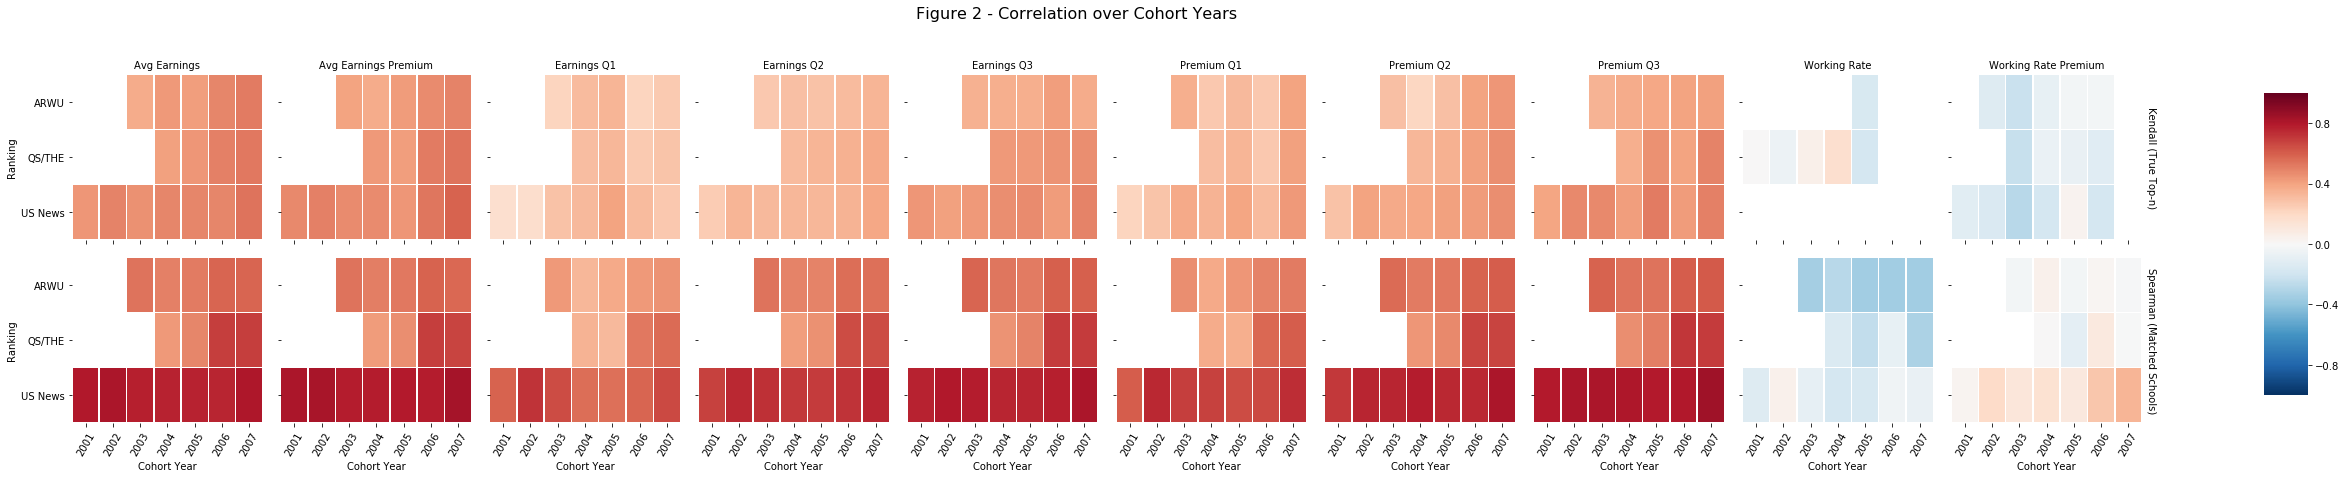

In [419]:
# create the cohort year aggregated data
cohort_year_agg = corr_mean_agg_by('Cohort Year')

# visualize correlations aggregated by cohort year
cohort_year_hm = sns.FacetGrid(cohort_year_agg, col='Metric', row='Correlation Type', margin_titles=True)
cbar_ax = cohort_year_hm.fig.add_axes([1.05, .2, .02, .7]) # create axis for color bar
cohort_year_hm.map_dataframe(draw_heatmap, 'Cohort Year', 'Ranking', 'Correlation', 
                             cbar_ax=cbar_ax)

# format
[plt.setp(ax.texts, text="") for ax in cohort_year_hm.axes.flat] # remove the original texts from margin_titles
cohort_year_hm.set_titles(row_template = '{row_name}', col_template = '{col_name}')
cohort_year_hm.fig.suptitle('Figure 2 - Correlation over Cohort Years', size=16, y=1.1)
cohort_year_hm.set_yticklabels(rotation=0)
cohort_year_hm.set_xticklabels(rotation=60)

plt.tight_layout()
cohort_year_hm.savefig('Figure 2 - Correlation over Cohort Years.png')
plt.show()

C:\Users\kevin\Anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


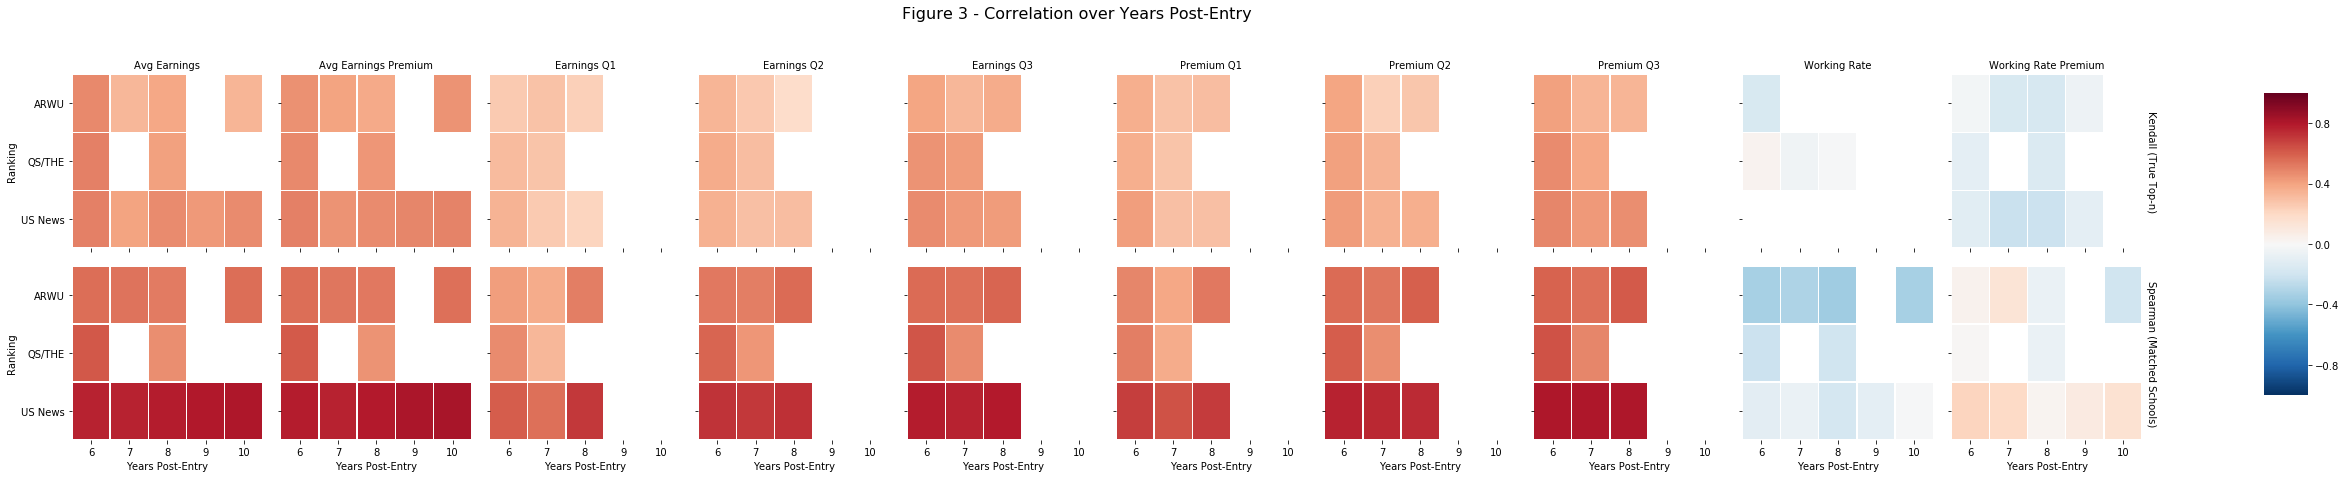

In [420]:
# create the cohort year aggregated data
years_pe_agg = corr_mean_agg_by('Years Post-Entry')

# visualize correlations aggregated by Years Post-Entry
years_pe_hm = sns.FacetGrid(years_pe_agg, col='Metric', row='Correlation Type', margin_titles=True)
cbar_ax = years_pe_hm.fig.add_axes([1.05, .2, .02, .7]) # create axis for color bar
years_pe_hm.map_dataframe(draw_heatmap, 'Years Post-Entry', 'Ranking', 'Correlation', 
                             cbar_ax=cbar_ax)

# format
[plt.setp(ax.texts, text="") for ax in years_pe_hm.axes.flat] # remove the original texts from margin_titles
years_pe_hm.set_titles(row_template = '{row_name}', col_template = '{col_name}')
years_pe_hm.fig.suptitle('Figure 3 - Correlation over Years Post-Entry', size=16, y=1.1)
years_pe_hm.set_yticklabels(rotation=0)

plt.tight_layout()
years_pe_hm.savefig('Figure 3 - Correlation over Years Post-Entry.png')
plt.show()

## Range and Density of Errors
Having seen that for consumers who are focused on only the schools result in a fairly strong correlation, the question is how much room for error there is between a given ranking and its real ranking. From Spearman's correlation it seems that in the case of US News there aren't serious ranges of errors, but how much stock should be put on a rank 5 vs a rank 10? To do this we look at the range and density of errors.

In [421]:
def create_error_df(): # compiles data frames aggregated at ranking and metric to find average error
    
    # initialize final data frame
    df = pd.DataFrame(columns=['Ranking', 'Metric', 'True Rank', 'True Tier', 'Predicted Rank', 'Predicted Tier'])
                               
    
    for i in range(3):
        for metric in metrics:
            data = frames[i+1, metric, True]
            
            # add real rank and error as well as percentile rank for binning into quartiles
            data['Ranking'] = ranking_dict[i+1]
            data['Metric'] = metric
            data['Predicted Rank'] = data['Inverted Rank'].groupby(
                ['Cohort Year', 'Years Post-Entry']).rank(ascending=False)            
            data['True Rank'] = data['Inverted Result Rank'].groupby(
                ['Cohort Year', 'Years Post-Entry']).rank(ascending=False)
            data['Rank Error'] = data['True Rank'] - data['Predicted Rank']
            data['Predicted Rank Pct'] = data['Inverted Rank'].groupby(
                ['Cohort Year', 'Years Post-Entry']).rank(pct=True, ascending=False)            
            data['True Rank Pct'] = data['Inverted Result Rank'].groupby(
                ['Cohort Year', 'Years Post-Entry']).rank(pct=True, ascending=False)
            
            pred_cond = [(data['Predicted Rank Pct'] <= 0.25), 
                          (data['Predicted Rank Pct'] <= 0.5),
                          (data['Predicted Rank Pct'] <= 0.75)]
            pred_tier = ['Tier 1', 'Tier 2', 'Tier 3']
            true_cond = [(data['True Rank Pct'] <= 0.25), 
                          (data['True Rank Pct'] <= 0.5),
                          (data['True Rank Pct'] <= 0.75)]
            true_tier = ['Tier 1', 'Tier 2', 'Tier 3']
            
            data['Predicted Tier'] = np.select(pred_cond, pred_tier, default='Tier 4')
            data['True Tier'] = np.select(true_cond, true_tier, default='Tier 4')
            
            df = df.append(data.reset_index())

        
    return df[['Cohort Year','Metric','Ranking','Predicted Rank', 'Predicted Tier',
               'Rank Error','True Rank', 'True Tier','Years Post-Entry']]

error_df = create_error_df()
error_df.head()

,Cohort Year,Metric,Ranking,Predicted Rank,Predicted Tier,Rank Error,True Rank,True Tier,Years Post-Entry
0,2001.0,Avg Earnings,US News,5.0,Tier 1,-4.0,1.0,Tier 1,8.0
1,2001.0,Avg Earnings,US News,2.5,Tier 1,-0.5,2.0,Tier 1,8.0
2,2001.0,Avg Earnings,US News,6.5,Tier 1,-3.5,3.0,Tier 1,8.0
3,2001.0,Avg Earnings,US News,6.5,Tier 1,-2.5,4.0,Tier 1,8.0
4,2001.0,Avg Earnings,US News,23.5,Tier 2,-18.0,5.5,Tier 1,8.0


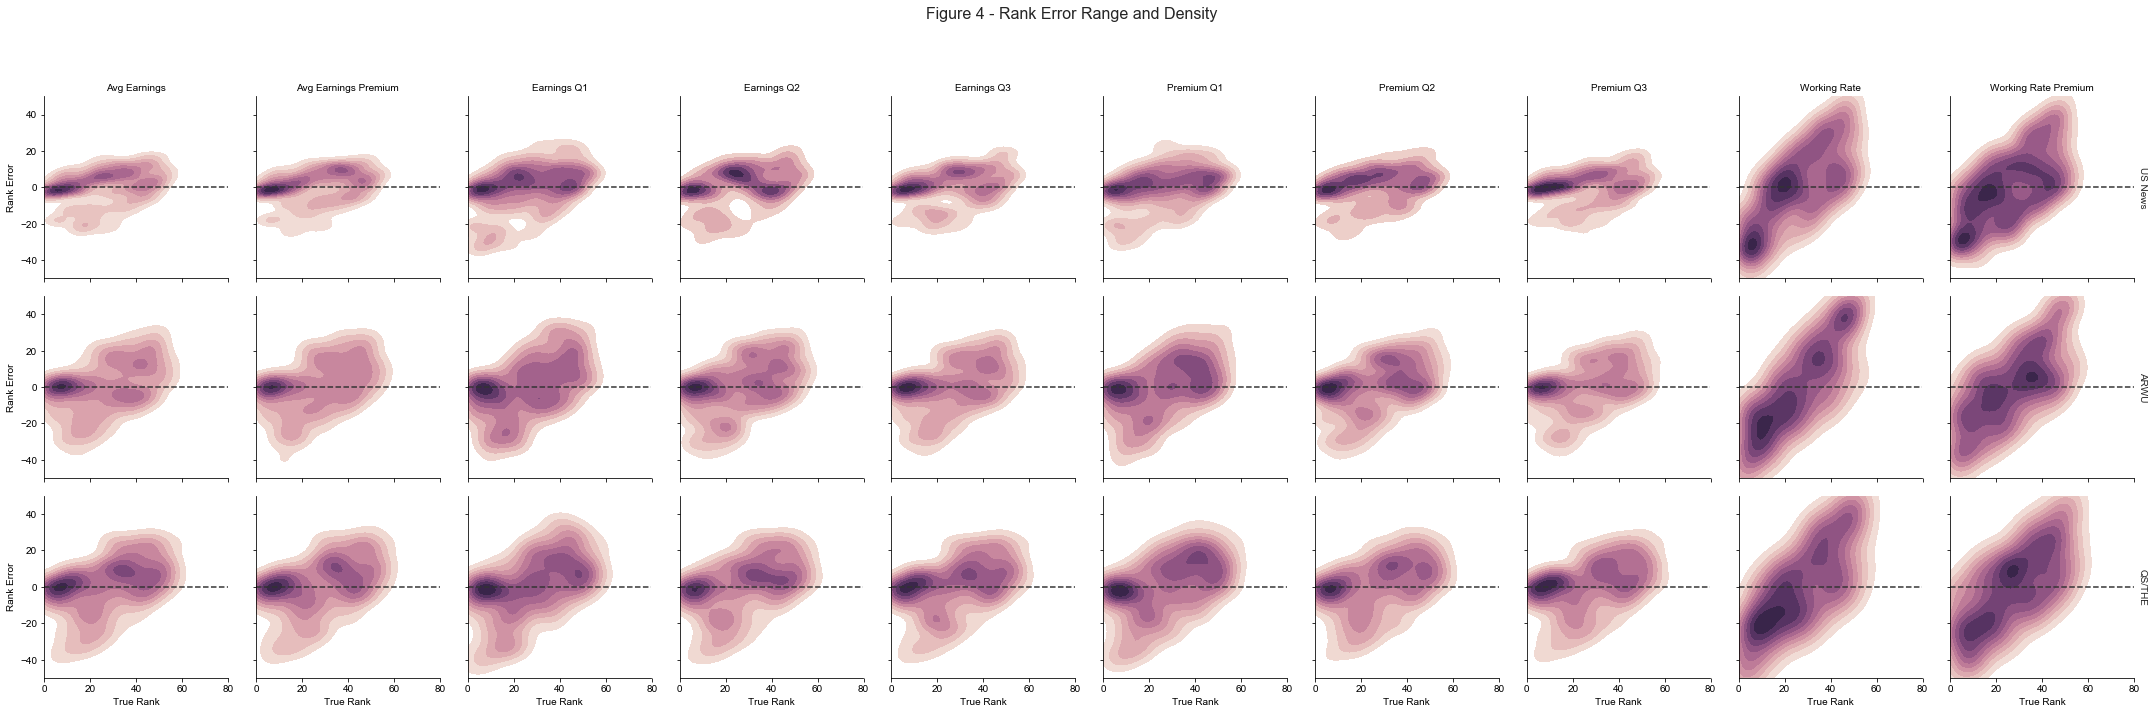

In [422]:
# visualize errors
err_dist = sns.FacetGrid(error_df, col='Metric', row='Ranking', margin_titles=True)
err_dist = err_dist.map(sns.kdeplot, 'True Rank', 'Rank Error', shade=True, shade_lowest=False, legend=True,
                        cmap=sns.cubehelix_palette(light=1, as_cmap=True))

#cbar_ax = err_dist.fig.add_axes([1.05, .2, .02, .7]) # create axis for color bar

# format
sns.set_style('whitegrid')
err_dist.axes[0,0].set_ylim(-50,50)
err_dist.axes[0,0].set_xlim(0,)
x_len = err_dist.axes[0,0].get_xlim()
for ax in err_dist.axes.flat:
    ax.plot((0,x_len[1]), (0,0), c=".2", ls="--") # plot 0 error reference line
    
[plt.setp(ax.texts, text='') for ax in err_dist.axes.flat] # remove the original texts from margin_titles
err_dist.set_titles(row_template = '{row_name}', col_template = '{col_name}')
err_dist.fig.suptitle('Figure 4 - Rank Error Range and Density', size=16, y=1.1)

err_dist.savefig('Figure 4 - Rank Error Range and Density.png')
plt.show()

It looks like in many cases the possibility for error (especially on the over-ranking side) can be quite high. However, we should also consider whether choosing by tiers of rankings offers more reasonable application of rankings.

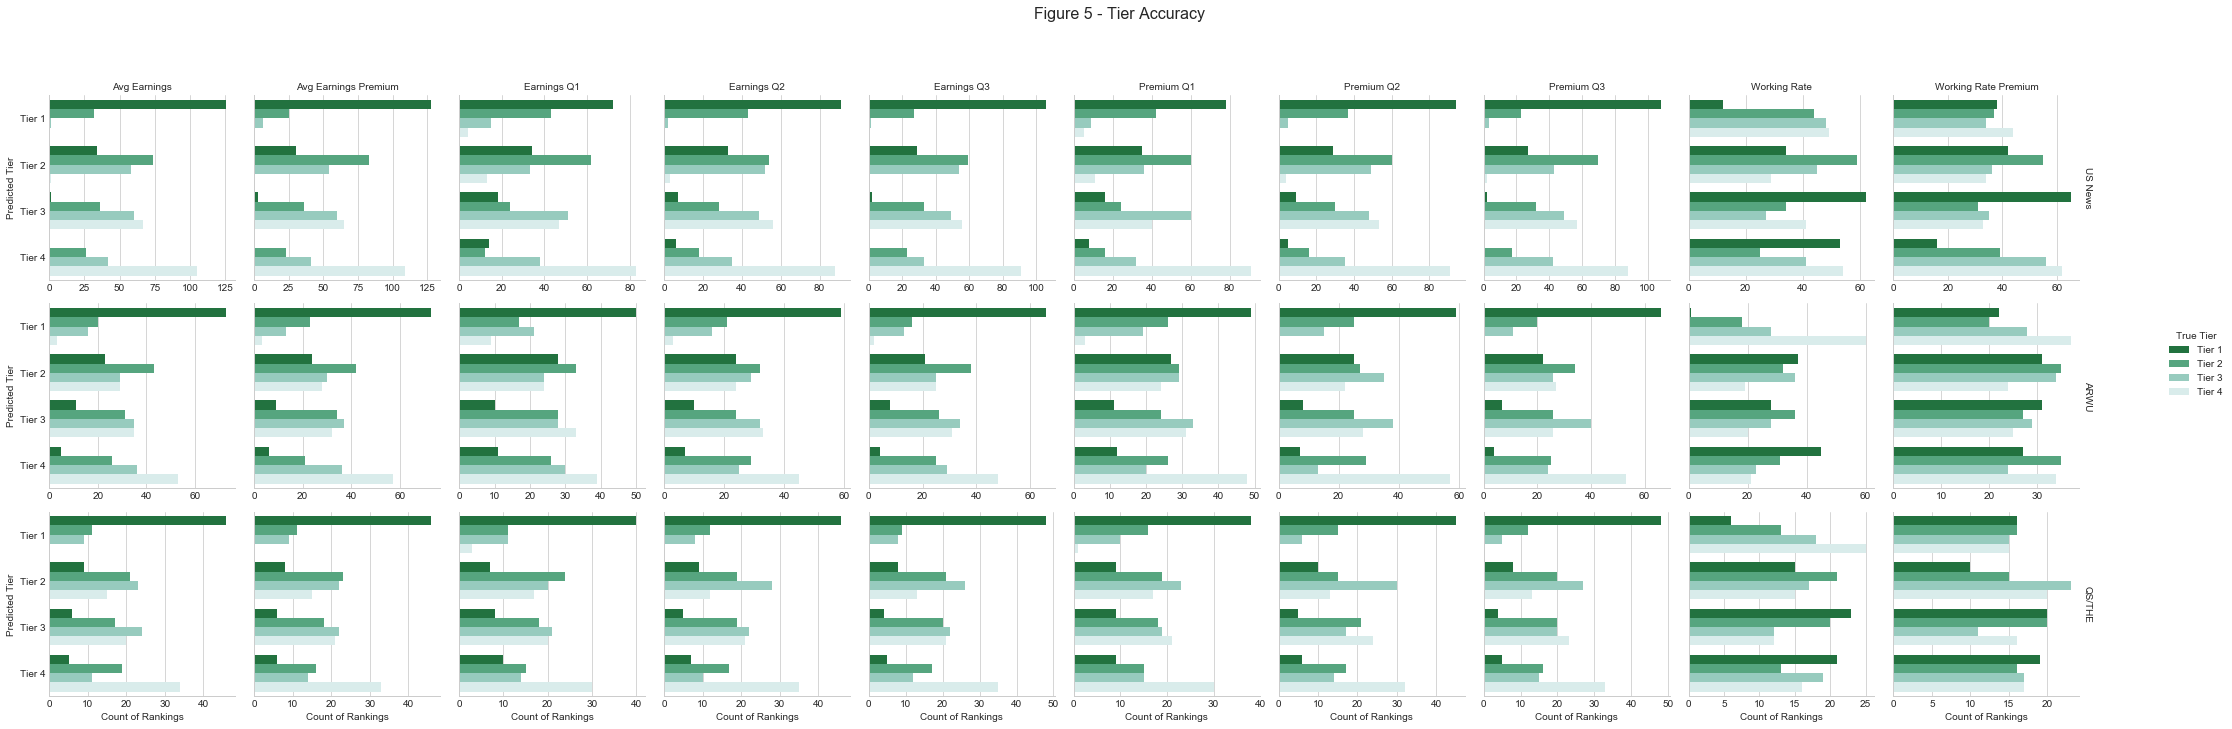

In [423]:
# visualize errors
tier_acc = sns.FacetGrid(error_df, col='Metric', row='Ranking',
                         sharex=False, legend_out=True, margin_titles=True)
tier_acc = tier_acc.map_dataframe(sns.countplot, y='Predicted Tier', hue='True Tier', orient='h', 
                       palette='BuGn_r', order=['Tier 1', 'Tier 2', 'Tier 3', 'Tier 4']).add_legend()

# format
sns.set_style('whitegrid')
[plt.setp(ax.texts, text='') for ax in tier_acc.axes.flat] # remove the original texts from margin_titles
tier_acc.set_titles(row_template = '{row_name}', col_template = '{col_name}')
tier_acc._legend.set_title('True Tier')
tier_acc.set_xlabels('Count of Rankings')
tier_acc.set_ylabels('Predicted Tier')
tier_acc.fig.suptitle('Figure 5 - Tier Accuracy', size=16, y=1.1)

tier_acc.savefig('Figure 5 - Tier Accuracy.png')
plt.show()